# Pyro Examples

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

### Train / Test Split

In [5]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.18397,0.72014,1.11967
1,2010-01-10,825891,1.18397,0.81490,1.17860
2,2010-01-17,659173,1.20338,0.73909,1.11967
3,2010-01-24,507651,1.16456,0.81490,1.10788
4,2010-01-31,538617,1.08693,0.77699,1.07253


## MAP Fit and Predict

In [7]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True
)

In [8]:
lgt_map.fit(df=train_df)

step    0 loss = 578.88
step    1 loss = 527.46
step    2 loss = 475.65
step    3 loss = 423.24
step    4 loss = 369.54
step    5 loss = 315.22
step    6 loss = 260.51
step    7 loss = 206.09
step    8 loss = 152.5
step    9 loss = 100.6
step   10 loss = 51.402
step   11 loss = 6.2315
step   12 loss = -33.465
step   13 loss = -70.631
step   14 loss = -107.27
step   15 loss = -144.49
step   16 loss = -178.33
step   17 loss = -214.87
step   18 loss = -249.36
step   19 loss = -283.79
step   20 loss = -312.46
step   21 loss = -345.54
step   22 loss = -373.68
step   23 loss = -402.99
step   24 loss = -422.5
step   25 loss = -448.72
step   26 loss = -464.16
step   27 loss = -483.35
step   28 loss = -486.61
step   29 loss = -499.38
step   30 loss = -486.77
step   31 loss = -496.42
step   32 loss = -496.2
step   33 loss = -500.91
step   34 loss = -495.9
step   35 loss = -503.98
step   36 loss = -500.78
step   37 loss = -506.64
step   38 loss = -496.65
step   39 loss = -505.37
step   40 loss = 

In [9]:
predicted_df = lgt_map.predict(df=test_df)

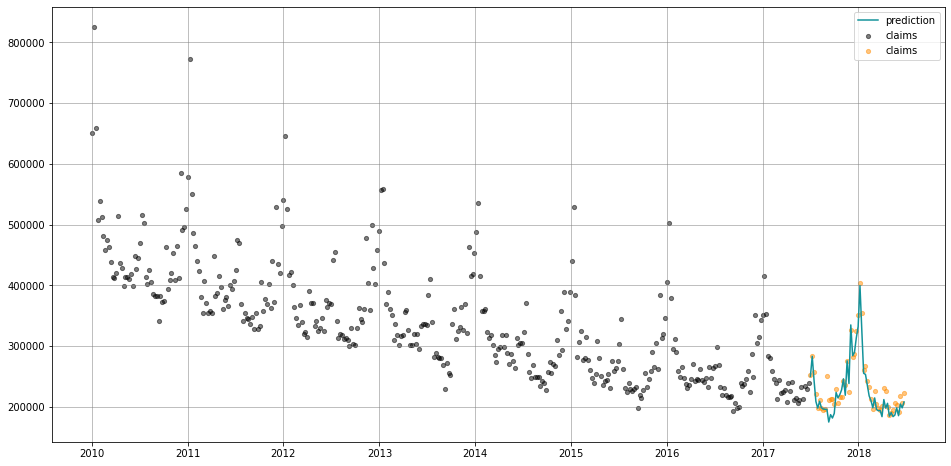

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.

In [11]:
lgt_vi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    seed=8888,
    inference_engine='pyro',
    sample_method='vi',
    predict_method='full',
    n_bootstrap_draws=500
)

In [12]:
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 658.75, scale = 0.11668
step  100 loss = -417.29, scale = 0.33219


In [13]:
predicted_df = lgt_vi.predict(df=test_df)

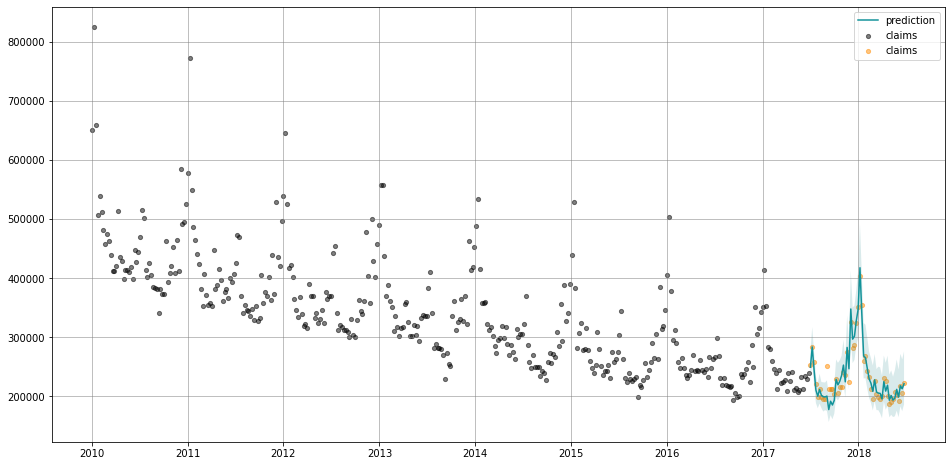

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Fit with Regressors

In [16]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map'
)

In [17]:
lgt_reg_map.fit(df=train_df)

AttributeError: 'LGTModel' object has no attribute 'fix_reg_coef_sd'

In [18]:
predicted_df = lgt_reg_map.predict(df=test_df)

AttributeError: 'NoneType' object has no attribute 'items'

In [19]:
predicted_df.head(5)

,week,5,50,95
0,2017-07-02,227496.38588,249383.48505,275321.23054
1,2017-07-09,254525.44262,283659.60672,317576.10763
2,2017-07-16,220418.55827,245231.75363,274947.41032
3,2017-07-23,188891.14121,210693.54391,233975.56217
4,2017-07-30,180022.02194,200281.96193,222058.17426


In [ ]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_reg_map.date_col, actual_col=lgt_reg_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [ ]:
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

In [ ]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')